In [ ]:
import sys
print(sys.path)


In [1]:
import numpy as np
import pandas as pd
import nltk
import mlflow
import mlflow.sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from datetime import datetime
import matplotlib.pyplot as plt

# Start MLflow run
mlflow.set_experiment("your_experiment_name")
with mlflow.start_run():
    # Task 1: Preprocessing and TF-IDF Vectorization
    nltk.data.path.append('C:\\Users\\ABREHAM\\Downloads\\punkt\\punkt')

    data = pd.read_csv('../assets/rating.csv', nrows=1000)  # Change the number of rows as needed

    def preprocess_text(text):
        tokens = word_tokenize(text)
        tokens = [word.lower() for word in tokens if word.isalnum()]
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        return ' '.join(tokens)

    data['clean_title'] = data['title'].apply(preprocess_text)
    data['clean_content'] = data['content'].apply(preprocess_text)

    vectorizer = TfidfVectorizer()
    X_title = vectorizer.fit_transform(data['clean_title'])
    X_content = vectorizer.transform(data['clean_content'])
    X_title_sparse = X_title.tocsr()
    X_content_sparse = X_content.tocsr()
    similarity_scores = cosine_similarity(X_title_sparse, X_content_sparse)
    mlflow.log_metric("average_similarity", np.mean(similarity_scores))

    # Task 2: Topic Modeling with LDA
    vectorizer = TfidfVectorizer(max_features=1000, max_df=0.85, stop_words='english')
    X = vectorizer.fit_transform(data['clean_text'])

    lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
    lda_output = lda_model.fit_transform(X)
    mlflow.log_param("n_components", 10)
    mlflow.log_metric("log_likelihood", lda_model.score(X))

    # Task 3: Analyzing Topic Trends
    data['published_at'] = pd.to_datetime(data['published_at'])
    topic_trends = data.groupby(['published_at', 'topic_category']).size().unstack(fill_value=0)
    reference_date = datetime(2020, 1, 1)
    date_column = (data['published_at'] - reference_date).dt.days
    date_column_expanded = np.repeat(date_column, len(topic_trends.columns))
    topic_category_expanded = np.tile(topic_trends.columns, len(date_column))
    count_values = topic_trends.values.flatten()

    plt.figure(figsize=(12, 8))
    plt.scatter(date_column_expanded, topic_category_expanded, c=count_values, cmap='viridis')
    plt.title('Topic Trends Over Time')
    plt.xlabel('Days Since Reference Date')
    plt.ylabel('Topic Category')
    plt.colorbar(label='Article Count')
    plt.show()

    # Task 4: Clustering Topics
    documents = data['clean_text']
    vectorizer = TfidfVectorizer(max_features=1000, max_df=0.85, stop_words='english')
    X = vectorizer.fit_transform(documents)

    n_topics = 7
    lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda_output = lda_model.fit_transform(X)

    n_clusters = 6
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(cosine_similarity(lda_model.components_))

    topic_clusters = {}
    for topic_idx, cluster_label in enumerate(cluster_labels):
        if cluster_label not in topic_clusters:
            topic_clusters[cluster_label] = []
        topic_clusters[cluster_label].append(topic_idx)

    for cluster_label, topics in topic_clusters.items():
        print(f"Cluster {cluster_label + 1}:")
        print([feature_names[i] for i in lda_model.components_[topic_idx].argsort()[:-n_top_words - 1:-1]])

    # Task 5: Clustering News Articles by Events
    lda_model = LatentDirichletAllocation(n_components=1000, random_state=42)
    lda_output = lda_model.fit_transform(X)
    similarity_matrix = cosine_similarity(lda_model.components_)

    n_clusters = 10
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(similarity_matrix.T)
    data['cluster_label'] = cluster_labels

    num_events = len(data['cluster_label'].unique())
    mlflow.log_metric("num_events", num_events)

    earliest_reporting = data.groupby('source_name')['cluster_label'].min()
    earliest_reporting = earliest_reporting.sort_values()
    print("News sites reporting events the earliest:")
    print(earliest_reporting)

    event_counts = data['cluster_label'].value_counts()
    events_highest_reporting = event_counts.idxmax()
    print(f"Event(s) with the highest reporting: {events_highest_reporting}")

    source_cluster_matrix = pd.pivot_table(data, index='source_name', columns='cluster_label', aggfunc='size', fill_value=0)
    correlation = source_cluster_matrix.corr()
    print("Correlation between news sites reporting events:")
    print(correlation)


2024/04/13 04:43:16 INFO mlflow.tracking.fluent: Experiment with name 'your_experiment_name' does not exist. Creating a new experiment.


KeyError: 'clean_text'

In [2]:
import nltk
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


# Set the NLTK data path to the directory where you extracted the NLTK data
nltk.data.path.append('C:\\Users\\ABREHAM\\Downloads\\punkt\\punkt')

# Load a sample subset of the dataset to reduce memory usage
data = pd.read_csv('../assets/rating.csv', nrows=1000)  # Change the number of rows as needed

# Preprocessing function
def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove punctuation and lowercase
    tokens = [word.lower() for word in tokens if word.isalnum()]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Preprocess title and content columns
data['clean_title'] = data['title'].apply(preprocess_text)
data['clean_content'] = data['content'].apply(preprocess_text)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X_title = vectorizer.fit_transform(data['clean_title'])
X_content = vectorizer.transform(data['clean_content'])

# Convert TF-IDF matrices to sparse format
X_title_sparse = X_title.tocsr()
X_content_sparse = X_content.tocsr()

# Calculate cosine similarity between title and content vectors
similarity_scores = cosine_similarity(X_title_sparse, X_content_sparse)

# Print similarity scores
print("Similarity Scores between Title and Content Keywords:")
for i, score in enumerate(similarity_scores):
    print(f"Article {i + 1}: {score}")


Similarity Scores between Title and Content Keywords:
Article 1: [0.44132213 0.         0.         0.         0.         0.
 0.         0.         0.         0.0745389  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.09135894 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.06281457 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Article 516: [0.         0.         0.         0.         0.         0.
 0.07380658 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.06304131 0.         0.         0.         0.         0.
 0.         0.         0.11157709 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.       

In [33]:


# Preprocess 'content' column and create 'clean_text' column
data['clean_text'] = data['content'].apply(preprocess_text)

# Create document-term matrix
vectorizer = TfidfVectorizer(max_features=1000, max_df=0.85, stop_words='english')
X = vectorizer.fit_transform(data['clean_text'])

# Apply LDA topic modeling algorithm
lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
lda_output = lda_model.fit_transform(X)

# Define known topic categories
topic_categories = {
    0: "Breaking News",
    1: "Politics",
    2: "World News",
    3: "Business/Finance",
    4: "Technology",
    5: "Science",
    6: "Health",
    7: "Entertainment",
    8: "Sports",
    9: "Environment",
    # Add more categories as needed
}

# Categorize documents into known topic categories
topic_assignments = np.argmax(lda_output, axis=1)
data['topic_category'] = [topic_categories[i] for i in topic_assignments]

# Analyze topics
# Print top terms associated with each topic
n_top_words = 10
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    print(f"Topic {topic_idx + 1}:")
    print([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

# Print document-topic assignments
print(data[['clean_text', 'topic_category']])


Topic 1:
['graphite', 'china', 'deposit', 'mauritius', 'world', 'holding', 'export', 'communiqué', 'philippine', 'natural']
Topic 2:
['state', 'form', 'come', 'southern', 'sultan', 'home', 'ai', 'new', 'time', 'forum']
Topic 3:
['2023', 'october', 'north', 'going', 'space', 'newswire', 'president', 'germany', 'tsxv', 'globe']
Topic 4:
['hurricane', 'mexico', 'acapulco', 'otis', 'maldives', 'storm', 'president', 'said', 'human', 'category']
Topic 5:
['european', 'western', 'albania', 'left', 'said', 'warned', 'product', 'central', 'customer', 'myanmar']
Topic 6:
['2023', 'company', 'newswire', 'globe', 'energy', 'russian', 'power', 'october', 'president', 'result']
Topic 7:
['cup', 'world', 'nigeria', 'super', 'game', 'eagle', 'friendly', 'france', 'sport', 'punch']
Topic 8:
['myanmar', 'rfa', 'image', 'burmese', 'people', 'junta', 'getty', 'year', 'report', 'exclusive']
Topic 9:
['news', 'africa', '2023', 'li', 'alliance', 'october', 'italy', 'following', 'report', 'south']
Topic 10:
[

In [38]:
print(data.columns)

Index(['article_id', 'source_id', 'source_name', 'author', 'title',
       'description', 'url', 'url_to_image', 'published_at', 'content',
       'category', 'article', 'title_sentiment', 'clean_title',
       'clean_content', 'clean_text', 'topic_category'],
      dtype='object')


Topic 1:
['graphite', 'china', 'deposit', 'mauritius', 'world', 'holding', 'export', 'communiqué', 'philippine', 'natural']
Topic 2:
['state', 'form', 'come', 'southern', 'sultan', 'home', 'ai', 'new', 'time', 'forum']
Topic 3:
['2023', 'october', 'north', 'going', 'space', 'newswire', 'president', 'germany', 'tsxv', 'globe']
Topic 4:
['hurricane', 'mexico', 'acapulco', 'otis', 'maldives', 'storm', 'president', 'said', 'human', 'category']
Topic 5:
['european', 'western', 'albania', 'left', 'said', 'warned', 'product', 'central', 'customer', 'myanmar']
Topic 6:
['2023', 'company', 'newswire', 'globe', 'energy', 'russian', 'power', 'october', 'president', 'result']
Topic 7:
['cup', 'world', 'nigeria', 'super', 'game', 'eagle', 'friendly', 'france', 'sport', 'punch']
Topic 8:
['myanmar', 'rfa', 'image', 'burmese', 'people', 'junta', 'getty', 'year', 'report', 'exclusive']
Topic 9:
['news', 'africa', '2023', 'li', 'alliance', 'october', 'italy', 'following', 'report', 'south']
Topic 10:
[

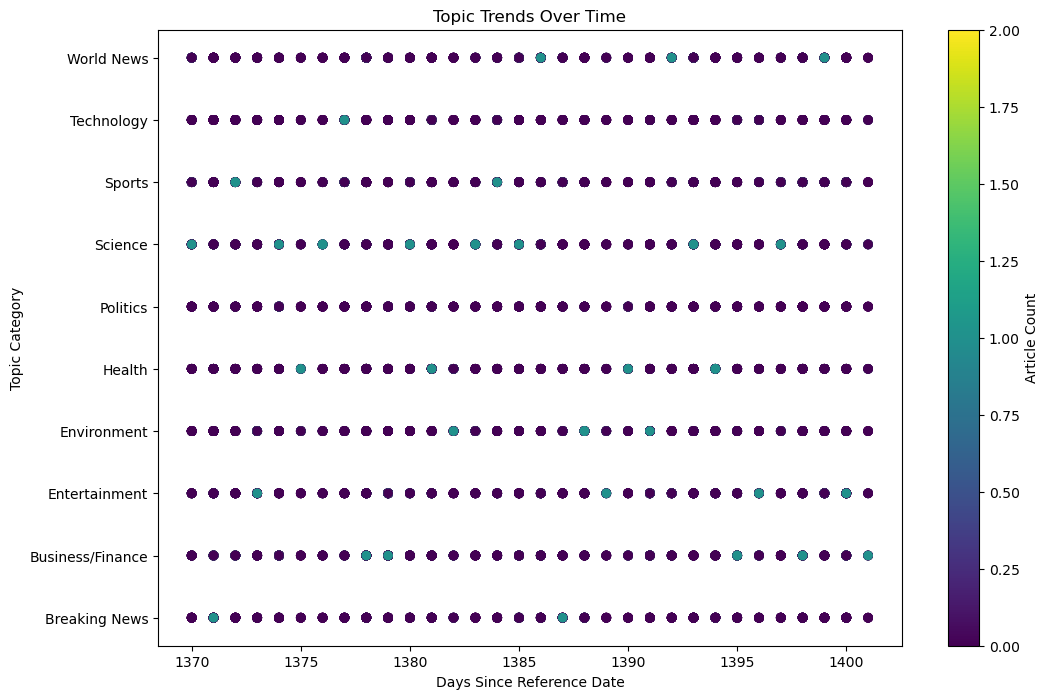

In [58]:

from datetime import datetime


n_top_words = 10
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    print(f"Topic {topic_idx + 1}:")
    print([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

# Group data by website and count unique topics
website_diversity = data.groupby('source_name')['topic_category'].nunique()
most_diverse_website = website_diversity.idxmax()

print("Websites Reporting Most Diverse Topics:")
print(website_diversity)
print(f"The website with the most diverse topics is: {most_diverse_website}")

data['published_at'] = pd.to_datetime(data['published_at'])
topic_trends = data.groupby(['published_at', 'topic_category']).size().unstack(fill_value=0)
reference_date = datetime(2020, 1, 1)
date_column = (data['published_at'] - reference_date).dt.days
date_column = date_column[:len(topic_trends.index)]


date_column_expanded = np.repeat(date_column, len(topic_trends.columns))
topic_category_expanded = np.tile(topic_trends.columns, len(date_column))
count_values = topic_trends.values.flatten()

# Visualize topic trends
plt.figure(figsize=(12, 8))
plt.scatter(date_column_expanded, topic_category_expanded, c=count_values, cmap='viridis')
plt.title('Topic Trends Over Time')
plt.xlabel('Days Since Reference Date')
plt.ylabel('Topic Category')
plt.colorbar(label='Article Count')
plt.show()

In [62]:
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

documents = data['clean_text']

vectorizer = TfidfVectorizer(max_features=1000, max_df=0.85, stop_words='english')
X = vectorizer.fit_transform(documents)

n_topics = 7 
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_output = lda_model.fit_transform(X)

n_top_words = 10
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    print(f"Topic {topic_idx + 1}:")
    print([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

similarity_matrix = cosine_similarity(lda_model.components_)


n_clusters = 6 # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(similarity_matrix)

# Assign cluster labels to topics
topic_clusters = {}
for topic_idx, cluster_label in enumerate(cluster_labels):
    if cluster_label not in topic_clusters:
        topic_clusters[cluster_label] = []
    topic_clusters[cluster_label].append(topic_idx)

# Interpret clusters
for cluster_label, topics in topic_clusters.items():
    print(f"Cluster {cluster_label + 1}:")
    for topic_idx in topics:
        print(f"  - Topic {topic_idx + 1}: {', '.join([feature_names[i] for i in lda_model.components_[topic_idx].argsort()[:-n_top_words - 1:-1]])}")
    print()

Topic 1:
['country', 'china', 'right', 'india', 'military', 'nation', 'united', 'said', 'mauritius', 'limited']
Topic 2:
['mexico', 'hurricane', 'israel', 'acapulco', 'storm', 'otis', 'state', 'government', 'national', 'force']
Topic 3:
['2023', 'newswire', 'globe', 'pleased', 'people', 'myanmar', 'company', 'border', 'president', 'li']
Topic 4:
['new', 'reuters', 'news', 'gas', 'report', 'energy', 'monday', '2023', 'company', 'bank']
Topic 5:
['super', 'nigeria', 'friendly', 'eagle', 'italy', 'punch', 'sport', 'international', 'game', 'arabia']
Topic 6:
['2023', 'getty', 'image', 'company', 'people', 'business', 'li', 'region', 'globe', 'november']
Topic 7:
['world', 'france', 'cup', 'rfa', 'burmese', 'junta', 'rugby', 'new', 'zealand', 'final']


c:\Users\ABREHAM\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\ABREHAM\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster 6:
  - Topic 1: country, china, right, india, military, nation, united, said, mauritius, limited

Cluster 2:
  - Topic 2: mexico, hurricane, israel, acapulco, storm, otis, state, government, national, force

Cluster 4:
  - Topic 3: 2023, newswire, globe, pleased, people, myanmar, company, border, president, li
  - Topic 6: 2023, getty, image, company, people, business, li, region, globe, november

Cluster 3:
  - Topic 4: new, reuters, news, gas, report, energy, monday, 2023, company, bank

Cluster 5:
  - Topic 5: super, nigeria, friendly, eagle, italy, punch, sport, international, game, arabia

Cluster 1:
  - Topic 7: world, france, cup, rfa, burmese, junta, rugby, new, zealand, final



In [72]:

# Extract relevant features (assuming 'clean_text' column contains preprocessed text)
documents = data['clean_text']

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000, max_df=0.85, stop_words='english')
X = vectorizer.fit_transform(documents)

lda_model = LatentDirichletAllocation(n_components=1000, random_state=42)
lda_output = lda_model.fit_transform(X)

# Cluster Analysis
similarity_matrix = cosine_similarity(lda_model.components_)
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(similarity_matrix.T)  # Transpose the similarity matrix

# Assign cluster labels to articles
data['cluster_label'] = cluster_labels

# Analyze clusters to determine the number of events covered
num_events = len(data['cluster_label'].unique())
print(f"Number of events covered in the data: {num_events}")

# Identify the news sites that report events the earliest
earliest_reporting = data.groupby('source_name')['cluster_label'].min()
earliest_reporting = earliest_reporting.sort_values()
print("News sites reporting events the earliest:")
print(earliest_reporting)

# Find events with the highest reporting
event_counts = data['cluster_label'].value_counts()
events_highest_reporting = event_counts.idxmax()
print(f"Event(s) with the highest reporting: {events_highest_reporting}")

# Calculate the correlation between news sites reporting events
source_cluster_matrix = pd.pivot_table(data, index='source_name', columns='cluster_label', aggfunc='size', fill_value=0)
correlation = source_cluster_matrix.corr()
print("Correlation between news sites reporting events:")
print(correlation)

c:\Users\ABREHAM\anaconda3\Lib\site-packages\sklearn\decomposition\_lda.py:891: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)
c:\Users\ABREHAM\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of events covered in the data: 10
News sites reporting events the earliest:
source_name
ABC News                        0
The Indian Express              0
RT                              0
Phys.Org                        0
NPR                             0
Marketscreener.com              0
International Business Times    0
GlobeNewswire                   0
Globalsecurity.org              0
Time                            0
Forbes                          0
Euronews                        0
ETF Daily News                  0
Digital Trends                  0
Deadline                        0
CNN                             0
CNA                             0
Business Insider                0
BBC News                        0
Al Jazeera English              0
The Punch                       0
The Times of India              0
Boing Boing                     4
The Verge                       5
Gizmodo.com                     5
Android Central                 5
Wired                